In [1]:
from importlib import reload
import sys
import pickle
import numpy as np 
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.ioff()
%matplotlib inline
import seaborn as sns
import pandas as pd
import itertools
from tqdm import tqdm
import time

## Load interchromosomal Hi-C data

In [2]:
hic_dir = '/home/braunger/masterthesis/save/processed_hic_data/'
data_dir = '/home/braunger/masterthesis/data/'
resol = 250000

In [3]:
# Function to get all interchromosomal hic data in long format
def get_interchromosomal_hic(cell_type, chr_list, hic_dir):
    
    chr_pairs = list(itertools.combinations(chr_list, 2))

    hic_all_inter = pd.DataFrame({'chr1': [], 'chr2': [], 'value': []})

    for pair in tqdm(chr_pairs):
        time.sleep(.01)
        chr1, chr2 = pair

        # read pickle
        hic = pd.read_pickle(hic_dir+'processed_hic_data_'+cell_type+'/final_BP250000_intraKR_interINTERKR/hic_chr'+str(chr1)+'_chr'+str(chr2)+'_norm1_filter3.pkl')
        # change colnames
        hic = hic.add_prefix('chr_'+str(chr2)+'_loc_')
        # change rownames and put rownames as a column
        hic = hic.T.add_prefix('chr_'+str(chr1)+'_loc_').T
        hic.reset_index(inplace=True)
        # convert df to long format
        hic = hic.melt(id_vars = ['index'])
        # change colnames 
        hic.columns = ['chr1', 'chr2', 'value']

        hic_all_inter = pd.concat([hic_all_inter, hic])
    return(hic_all_inter)

In [4]:
chr_list = list(range(1,22+1))
inter_IMR90 = get_interchromosomal_hic('IMR90', chr_list, hic_dir)
inter_old_fibroblasts = get_interchromosomal_hic('old_fibroblasts', chr_list, hic_dir)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 231/231 [03:19<00:00,  1.16it/s]


In [153]:
inter_IMR90.to_csv(hic_dir+'processed_hic_data_IMR90/final_BP250000_intraKR_interINTERKR/all_inter_long.csv', index = False)
inter_old_fibroblasts.to_csv(hic_dir+'processed_hic_data_old_fibroblasts/final_BP250000_intraKR_interINTERKR/all_inter_long.csv', index = False)
                   

In [81]:
# Normalize Hi-C Data
q = 0.75
q_IMR90 = np.quantile(inter_IMR90['value'], q)
q_old_fibroblasts = np.quantile(inter_old_fibroblasts['value'], q)

inter_IMR90['value_norm'] = inter_IMR90['value'].div(q_IMR90)
inter_old_fibroblasts['value_norm'] = inter_old_fibroblasts['value'].div(q_old_fibroblasts)

In [154]:
inter_IMR90.head()

,chr1,chr2,value,value_norm
0,chr_1_loc_0,chr_2_loc_0,0.000000,0.000000
1,chr_1_loc_250000,chr_2_loc_0,0.000000,0.000000
2,chr_1_loc_500000,chr_2_loc_0,3.692602,3.264491
3,chr_1_loc_750000,chr_2_loc_0,1.296140,1.145869
4,chr_1_loc_1000000,chr_2_loc_0,0.000000,0.000000


## Adhesome genes as reference

In [82]:
adhesome = pd.read_csv(data_dir+'adhesome_loci.csv')
adhesome['locus'] = 'chr_'+adhesome['chrom_int'].astype(str)+'_loc_'+(resol * adhesome['loci']).astype(str)
adhesome.head()

,Unnamed: 0,chrom,chrom_int,loci,gene,locus
0,34,chr1,1,65,FBLIM1,chr_1_loc_16250000
1,97,chr1,1,96,ASAP3,chr_1_loc_24000000
2,173,chr1,1,110,SLC9A1,chr_1_loc_27500000
3,158,chr1,1,128,FABP3,chr_1_loc_32000000
4,139,chr1,1,159,MACF1,chr_1_loc_39750000


In [83]:
IMR90_adhesome = inter_IMR90[inter_IMR90['chr1'].isin(adhesome['locus']) & 
                             inter_IMR90['chr2'].isin(adhesome['locus'])]

old_fibroblasts_adhesome = inter_old_fibroblasts[inter_old_fibroblasts['chr1'].isin(adhesome['locus']) & 
                                                 inter_old_fibroblasts['chr2'].isin(adhesome['locus'])]

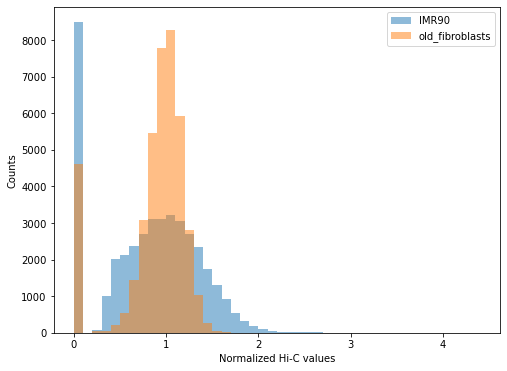

In [84]:
binwidth = 0.1

plt.figure(figsize=(8,6))
plt.hist(IMR90_adhesome['value_norm'], 
         bins=np.arange(min(IMR90_adhesome['value_norm']), max(IMR90_adhesome['value_norm']) + binwidth, binwidth), 
         alpha=0.5, label="IMR90")
plt.hist(old_fibroblasts_adhesome['value_norm'],
         bins=np.arange(min(old_fibroblasts_adhesome['value_norm']), max(old_fibroblasts_adhesome['value_norm']) + binwidth, binwidth), 
         alpha=0.5, label="old_fibroblasts")
plt.xlabel("Normalized Hi-C values")
plt.ylabel("Counts")
plt.legend(loc='upper right')
plt.show()